### Import Libraries

In [61]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
from sklearn.ensemble import AdaBoostRegressor # Random Forest

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

### Load Dataset

In [62]:
# Import Data
df = pd.read_csv('housing.csv')
df = df.dropna()

In [63]:
# Select input and output features
X = df.drop(columns = ['median_house_value'])
y = df['median_house_value']

# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,False,True,False


In [64]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement Random Forest Regressor

In [65]:
# Define your model
reg = AdaBoostRegressor(random_state = 42)

In [66]:
# Fit the model
start = time.time()            # Start Time
reg.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.5047409534454346s


#### Evaluate Prediction Performance on Test Set

In [67]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.45
RMSE on Test Set: 86612.35


#### Histogram of Residuals/Errors 

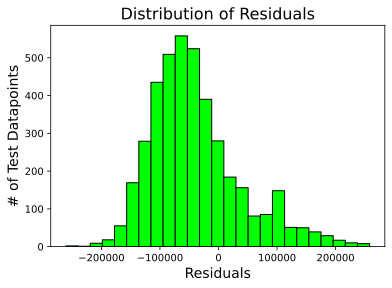

In [78]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig("residuals.svg");

#### Scatter Plot of Predicted Vs. Actual Values

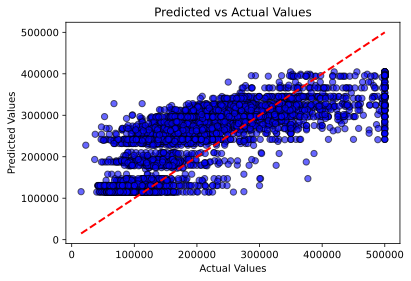

In [69]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("scatter.svg");

#### Feature Importance Plot

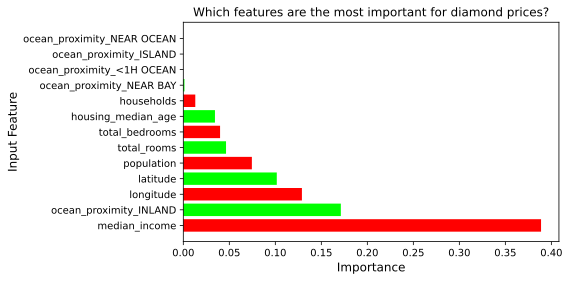

In [70]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for diamond prices?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

plt.savefig("feature_imp.svg");

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

[**See this link for detailed description on `MAPIE`**](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html)

In [71]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 1.4929051399230957s


In [72]:
# Predicted values
y_test_pred

array([267612.16875635, 179787.91044776, 270371.42280946, ...,
       130482.79481822, 147281.55194805, 173735.97203051])

In [73]:
# Prediction Intervals
y_test_pis

array([[[132069.10611402],
        [397322.72860636]],

       [[ 49818.90210731],
        [315994.10796485]],

       [[134800.81676529],
        [401620.78257689]],

       ...,

       [[-18003.62678487],
        [245033.09502685]],

       [[ 28671.5359636 ],
        [311981.69296504]],

       [[ 65147.02289765],
        [331881.71512941]]])

In [74]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
8291,500001.0,296778.85,152718.56,420838.96
6274,157900.0,262430.46,124042.16,391113.09
2997,100200.0,130482.79,-18003.63,245033.10
13440,127700.0,147281.55,28671.54,311981.69
14797,133700.0,173735.97,65147.02,331881.72


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [75]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.63%


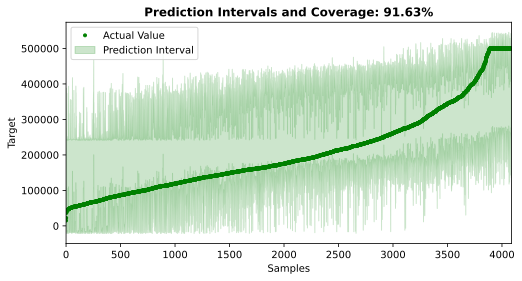

In [76]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);
plt.savefig("pred_int.svg");

### Save Model

In [77]:
# Creating the file where we want to write the model
reg_pickle = open('reg_diamond.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()